1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


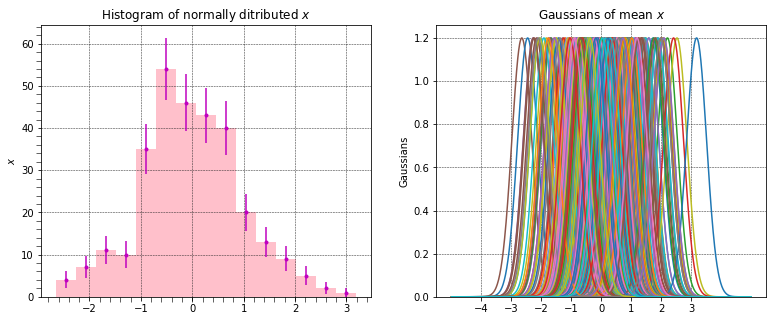

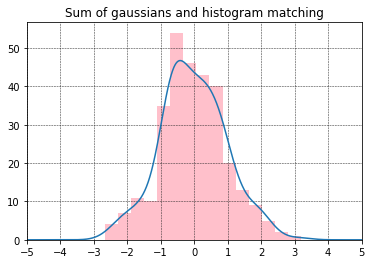

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm
import scipy
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter

# array normally distributed, with mean 0 and standard deviation 1
x=np.random.normal(loc=0.0, scale=1.0, size=300)

#build the figure 
fig=plt.figure(figsize=(13, 5))

###  HISTOGRAM  ###   ax1
ax1=fig.add_subplot(1,2,1)
ax1.hist(x, bins=15, range=None, histtype='bar', orientation='vertical', color='pink', label='x')

#set a proper y axis label
ax1.set_ylabel('$x$')

#proper value of y axis major ticks labels
import matplotlib.ticker as plticker
loc = plticker.MultipleLocator(base=10) # this locator puts ticks at regular intervals
ax1.yaxis.set_major_locator(loc)

#errors of the data points (the error being the poisson uncertainty)
y, bin_edges = np.histogram(x, bins=15)
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
plt.xticks(np.arange(-4, 4, step=1))
plt.errorbar(
    bin_centers,
    y,
    yerr = y**0.5,
    marker = '.',
    fmt='m.'
)

# minor ticks
ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
#ax1.xaxis.set_minor_formatter(FuncFormatter(minor_tick))
ax1.tick_params(which='minor', length=5, labelsize=8, labelcolor='0.25')

# add a grid
ax1.grid(linestyle="--", linewidth=0.5, color='.15', zorder=-10)

#title
ax1.set_title("Histogram of normally ditributed $x$")
###  GAUSSIANS  ###  ax2
ax2=fig.add_subplot(1,2,2)

# built of the gaussians
x_gauss=norm(loc=x[1], scale=1.06*x.std()*x.size**(-1/5))
x1 = np.linspace(-5,5, 1000)
sum_x_gauss=0
for i in range(len(x)):
    x_gauss=norm(loc=x[i], scale=1.06*x.std()*x.size**(-1/5))
    sum_x_gauss=x_gauss.pdf(x1)+sum_x_gauss
    ax2.plot(x1,x_gauss.pdf(x1))
ax2.set_ylabel('Gaussians')  
ax2.set_ylim(0,)
plt.xticks(np.arange(-4, 4, step=1))
# add a grid
ax2.grid(linestyle="--", linewidth=0.5, color='.15', zorder=-10)

#title
ax2.set_title("Gaussians of mean $x$")

plt.show()
fig.tight_layout()

# SUM OF THE GAUSSIANS, AND CHECK THE MATCHING WITH THE HISTOGRAM AFTER NORMALIZATION

#creating figure and axes for following plot
fig2= plt.figure()
ax4=fig2.add_subplot(1,1,1)

#area of the histogram
values, bins, _ =ax4.hist(x, bins=15, range=None, histtype='bar', orientation='vertical', color='pink', label='x')
area_histogram= sum(np.diff(bins)*values)

#area of the sum of the gaussians (computed in the for loop above)
area_sum_x_gauss=scipy.integrate.trapz(sum_x_gauss, x=x1)

# normalization factor
renorm=area_histogram/area_sum_x_gauss

#plot
ax4.plot(x1, sum_x_gauss*renorm)
ax4.grid(linestyle="--", linewidth=0.5, color='.15', zorder=-10)
plt.xticks(np.arange(-5, 6, step=1))
ax4.set_xlim(-5,5)
ax4.set_title("Sum of gaussians and histogram matching")
plt.show()
fig.tight_layout()

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: covariance is not positive-semidefinite.
  if sys.path[0] == '':


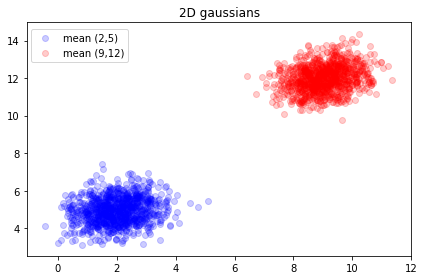

In [3]:
#function
import pandas as pd

def my_two_cats(mean): #lol
    
    N=1000
    #mean = [mean,mean+np.random.randint(0,10)]
    mean = [mean,mean+3]
    cov_symm= [[0.1,0.5],[0.6,0.1]]
    #cov = np.random.rand(2,2)
    #cov_symm = (cov + cov.T)/2
    gauss_x = np.random.multivariate_normal(mean, cov_symm, (N,))
    #gauss_y = np.random.multivariate_normal(mean, cov_symm, N)
    #gauss = pd.DataFrame(np.random.multivariate_normal(mean, cov, (N,)), columns=['gauss_x', 'gauss_y'])
    #gauss=pd.DataFrame({'gauss_x': [gauss for gauss in gauss_x],'gauss_y': [gauss for gauss in gauss_y]})
    return gauss_x

#create the two datasets
cat1=my_two_cats(2)
cat2=my_two_cats(9)

#plot
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
x=np.linspace(0,1000,cat1.size)
#print(cat1.shape)
ax.scatter(x=cat1[:,0], y=cat1[:,1], marker='o', c='b', edgecolor='b', label='mean (2,5)', alpha=0.2)
ax.scatter(x=cat2[:,0], y=cat2[:,1], marker='o', c='r', edgecolor='r',label='mean (9,12)', alpha=0.2)
#ax.scatter(x=cat1[:,1,0], y=cat1[:,1,1], marker='.', c='', edgecolor='r')
#ax.scatter(x=cat2['gauss_x'], y=cat2['gauss_y'], marker='.', c='',label='mean 4', edgecolor='r')
ax.legend(loc=(0.01, 0.83))
ax.set_title('2D gaussians')
#proper axis
import matplotlib.ticker as plticker
loc = plticker.MultipleLocator(base=100) # this locator puts ticks at regular intervals
#ax.xaxis.set_major_locator(loc)
#ax.set_xlim(-10,1010)
#ax.set_ylabel('Gaussians')  
fig.tight_layout()

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should you the `np.load()` function to load the file as a numpy array and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [4]:
!curl https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy

LinregressResult(slope=0.0032597701220305813, intercept=-0.1543281676306947, rvalue=0.04340351052255907, pvalue=8.717037183576494e-06, stderr=0.0007327014008445789)


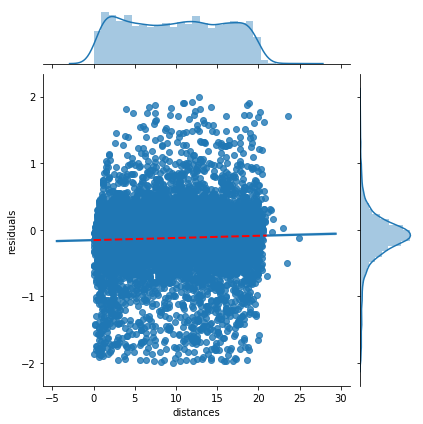

In [130]:
#load the data into the pandas datatframe
res_a=np.load('/Users/lucamanenti/Desktop/residuals_261.npy')
res_df = pd.DataFrame.from_records(res_a.tolist()) #ci ho messo 9870 anni a trovare .from_records C: accomplished!!

#variable "residual" in absolute value smaller than 2
res_df=res_df[abs(res_df['residuals'])<2]

#linear regression
print(scipy.stats.linregress(res_df['distances'],res_df['residuals']))

#seaborn
import seaborn as sns

res_jp = sns.jointplot(res_df['distances'],res_df['residuals'], kind="reg")

# Let me check if it matches with the previously obtained line
slope=0.0032597701220305813
intercept=-0.1543281676306947
x0=np.array([0, 21])
y0=x0*slope+intercept
plt.plot(x0, y0, linewidth=2, color='r', linestyle='dashed') #yaayyy :D